In [5]:
import os
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import torch.nn as nn

from PIL import Image
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
from google.colab import drive


In [12]:
drive.mount('/content/gdrive/')

!unzip -q /content/gdrive/My\ Drive/ML/dataset.zip -d train

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


**Подготовим датасет, лейблы получим по названиям папок**

In [44]:
RESCALE_SIZE = 150
BATCH_SIZE = 64
EPOCHS = 30
N_CLASSES = 4
DEVICE = torch.device("cuda")

transform = transforms.Compose([
transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder("/content/train/dataset", transform=transform)

train_length = int(len(dataset)*0.8)
test_length = len(dataset) - train_length

train_set, test_set = random_split(dataset, [train_length, test_length])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

**Построим простую конволюционную сеть**

In [45]:
class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(2*2*128, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

**Определим методы обучения и оценки**

In [46]:
 def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [47]:
def train(train_loader, model, epochs, batch_size):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \ train_acc {t_acc:0.4f} "

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            
            history.append((train_loss, train_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                        t_acc=train_acc))
            
    return history

In [48]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [49]:
net = SimpleCNN(N_CLASSES).to(DEVICE)
history = train(train_loader, net, EPOCHS, BATCH_SIZE)

epoch:   3%|▎         | 1/30 [00:48<23:22, 48.36s/it]


Epoch 001 train_loss: 1.0830 \ train_acc 0.5405 


epoch:   7%|▋         | 2/30 [01:36<22:32, 48.31s/it]


Epoch 002 train_loss: 0.8444 \ train_acc 0.6609 


epoch:  10%|█         | 3/30 [02:24<21:39, 48.14s/it]


Epoch 003 train_loss: 0.7487 \ train_acc 0.7014 


epoch:  13%|█▎        | 4/30 [03:12<20:52, 48.16s/it]


Epoch 004 train_loss: 0.6977 \ train_acc 0.7149 


epoch:  17%|█▋        | 5/30 [04:00<20:02, 48.08s/it]


Epoch 005 train_loss: 0.6462 \ train_acc 0.7431 


epoch:  20%|██        | 6/30 [04:48<19:14, 48.09s/it]


Epoch 006 train_loss: 0.6222 \ train_acc 0.7516 


epoch:  23%|██▎       | 7/30 [05:36<18:25, 48.08s/it]


Epoch 007 train_loss: 0.5788 \ train_acc 0.7738 


epoch:  27%|██▋       | 8/30 [06:24<17:36, 48.03s/it]


Epoch 008 train_loss: 0.5508 \ train_acc 0.7804 


epoch:  30%|███       | 9/30 [07:12<16:49, 48.09s/it]


Epoch 009 train_loss: 0.5222 \ train_acc 0.7908 


epoch:  33%|███▎      | 10/30 [08:00<15:59, 47.98s/it]


Epoch 010 train_loss: 0.5073 \ train_acc 0.8031 


epoch:  37%|███▋      | 11/30 [08:48<15:11, 47.95s/it]


Epoch 011 train_loss: 0.4737 \ train_acc 0.8178 


epoch:  40%|████      | 12/30 [09:36<14:21, 47.88s/it]


Epoch 012 train_loss: 0.4454 \ train_acc 0.8294 


epoch:  43%|████▎     | 13/30 [10:23<13:30, 47.67s/it]


Epoch 013 train_loss: 0.4218 \ train_acc 0.8356 


epoch:  47%|████▋     | 14/30 [11:10<12:40, 47.50s/it]


Epoch 014 train_loss: 0.4029 \ train_acc 0.8469 


epoch:  50%|█████     | 15/30 [11:57<11:51, 47.43s/it]


Epoch 015 train_loss: 0.3712 \ train_acc 0.8609 


epoch:  53%|█████▎    | 16/30 [12:44<11:00, 47.21s/it]


Epoch 016 train_loss: 0.3402 \ train_acc 0.8749 


epoch:  57%|█████▋    | 17/30 [13:30<10:10, 46.97s/it]


Epoch 017 train_loss: 0.3187 \ train_acc 0.8821 


epoch:  60%|██████    | 18/30 [14:17<09:23, 46.93s/it]


Epoch 018 train_loss: 0.3041 \ train_acc 0.8857 


epoch:  63%|██████▎   | 19/30 [15:04<08:35, 46.85s/it]


Epoch 019 train_loss: 0.2609 \ train_acc 0.9015 


epoch:  67%|██████▋   | 20/30 [15:51<07:48, 46.84s/it]


Epoch 020 train_loss: 0.2472 \ train_acc 0.9090 


epoch:  70%|███████   | 21/30 [16:38<07:02, 46.93s/it]


Epoch 021 train_loss: 0.2152 \ train_acc 0.9235 


epoch:  73%|███████▎  | 22/30 [17:25<06:16, 47.08s/it]


Epoch 022 train_loss: 0.1988 \ train_acc 0.9294 


epoch:  77%|███████▋  | 23/30 [18:12<05:29, 47.02s/it]


Epoch 023 train_loss: 0.1945 \ train_acc 0.9270 


epoch:  80%|████████  | 24/30 [18:59<04:41, 47.00s/it]


Epoch 024 train_loss: 0.1467 \ train_acc 0.9467 


epoch:  83%|████████▎ | 25/30 [19:46<03:54, 46.94s/it]


Epoch 025 train_loss: 0.1281 \ train_acc 0.9542 


epoch:  87%|████████▋ | 26/30 [20:34<03:08, 47.21s/it]


Epoch 026 train_loss: 0.1051 \ train_acc 0.9652 


epoch:  90%|█████████ | 27/30 [21:21<02:22, 47.38s/it]


Epoch 027 train_loss: 0.0912 \ train_acc 0.9675 


epoch:  93%|█████████▎| 28/30 [22:09<01:34, 47.43s/it]


Epoch 028 train_loss: 0.0928 \ train_acc 0.9674 


epoch:  97%|█████████▋| 29/30 [22:56<00:47, 47.27s/it]


Epoch 029 train_loss: 0.0596 \ train_acc 0.9804 


epoch: 100%|██████████| 30/30 [23:43<00:00, 47.44s/it]


Epoch 030 train_loss: 0.0748 \ train_acc 0.9727 


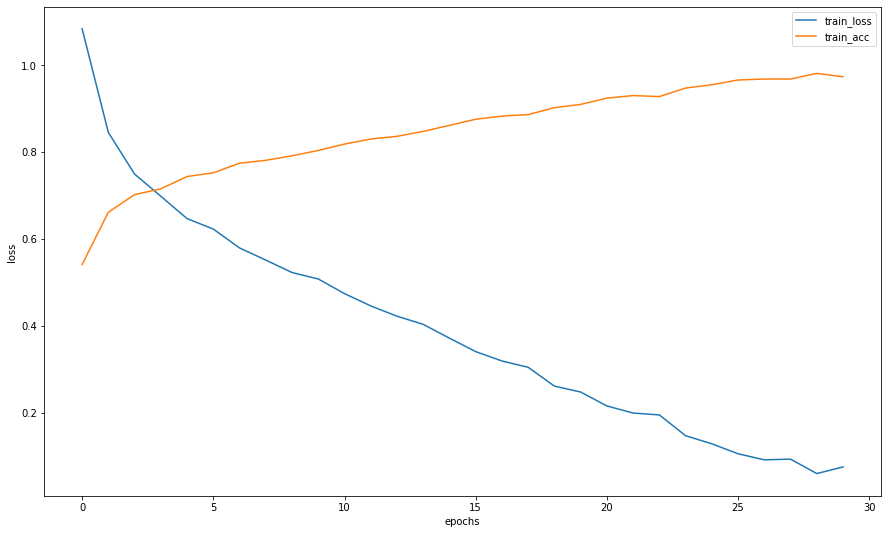

In [50]:
loss, acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(acc, label="train_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()